In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.sequence import TimeseriesGenerator
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, mean_squared_error, r2_score
import warnings
import os
from random import sample
import pickle
from sklearn.svm import SVR

warnings.filterwarnings('ignore')

## Functions

In [2]:
def save_model(model, filename):
    pickle.dump(model, open(filename, 'wb'))

def load_model(filename):
    return pickle.load(open(filename, 'rb'))

In [18]:
def predict_evaluate(prediction, true, graphName = 'Energy Usage Prediction', showplots=False):
    
    diff = [abs(prediction[i]-true[i]) for i in range(len(prediction))]
    
    mape = mean_absolute_percentage_error(true, prediction)
    mae = mean_absolute_error(true, prediction)
    maxae = max(diff)
    mse = mean_squared_error(true, prediction)
    
    if showplots:
        resultingPlot = plt.figure(figsize=(25,10))
        plt.plot(true, color='red', label='Original Usage')
        plt.plot(prediction, color='blue', label='Predicted Usage')
        #plt.plot(diff, color='green', label='Error')
        plt.title(graphName)
        plt.ylabel('kW')
        plt.legend()
        plt.show()
        print("Mean Absolute Percentage Error: ", mape)
        print("Mean Absolute Error: ", mae)
        print("Max Absolute Error: ", maxae)
        print("Mean Squared Error: ", mse)
    
    #return {"name":graphName, "resultingPlot": resultingPlot, "mape":mape, "mae":mae, "maxae":maxae, "mse":mse}
    return mae

In [4]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, MaxPooling2D, Conv2D, TimeDistributed, Flatten
from keras.callbacks import EarlyStopping

def define_model(past_window, num_features):
    
    #OPTIMIZAVEL
    model = Sequential()
    model.add(LSTM(units=128, return_sequences=True,input_shape=(past_window, num_features)))
    model.add(LSTM(units=64))
    model.add(Dense(units = 1))
    model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = 'mean_absolute_error')
    #model.summary()
    
    return model

def train(model, train_generator, showplot=False):
    early_stopping = EarlyStopping(monitor="loss", 
                                   patience=2, 
                                   mode="min")
    
    history = model.fit(train_generator, 
                                  epochs=24,
                                  shuffle = False, 
                                  callbacks=[early_stopping],
                                  verbose=0
                                   )
    
    loss_per_epoch = history.history['loss']
    
    if showplot:
        plt.plot(range(len(loss_per_epoch)), loss_per_epoch)
        

In [5]:
featuresNames = ['use', 'hour', 'weekday']
targetName = ['use']
past_window = 24


## GENERIC MODEL

In [6]:
directory = "../../datsets/LCL_Data_Transformed/train"
trainHouses = sorted(os.listdir(directory))

In [7]:
generic_Model = load_model("generic_Model/Generic_Model.sav")
x_scaler = load_model("generic_Model/x_scaler.sav")
y_scaler = load_model("generic_Model/y_scaler.sav")

SCALER

In [ ]:
#SCALERS
x_scaler = StandardScaler()
y_scaler = StandardScaler()

d = {key:[] for key in featuresNames}
allDF = pd.DataFrame(data=d)

for filename in trainHouses:
    
    f = os.path.join(directory, filename)
    if os.path.isfile(f):
        df = pd.read_csv(f, delimiter = ',')
        
        allDF = pd.concat([allDF, df[featuresNames]], ignore_index=True)

        
allFeatures = allDF[featuresNames].values
allTargets = allDF[targetName].values
        
x_scaler.fit(allFeatures)
y_scaler.fit(allTargets)

save_model(x_scaler, "generic_Model/x_scaler.sav")
save_model(y_scaler, "generic_Model/y_scaler.sav")



GENERIC MODEL

In [11]:
#generic_Model = define_model(past_window, len(featuresNames))

#Retreived already trained houses
fileTrain = open('generic_Model/trainedHouses.txt', 'r')
trainedHouses = fileTrain.read().splitlines()
fileTrain.close()

for filename in trainHouses:
    
    #already trained
    if filename in trainedHouses:
        continue
    
    print("Training with ", filename)
    
    #Read file
    f = os.path.join(directory, filename)
    if os.path.isfile(f):
        df = pd.read_csv(f, delimiter = ',')
        
        features = df[featuresNames].values
        target = df[targetName].values
        
        #SCALE
        x_train = x_scaler.transform(features)
        y_train = y_scaler.transform(target)
        
        #Time series
        batch_size=64
        train_generator = TimeseriesGenerator(x_train, y_train, length=past_window, batch_size=batch_size)
        
        train(generic_Model, train_generator)
        
        #Save model and update trained houses
        save_model(generic_Model, "generic_Model/Generic_Model.sav")
        fileTrain = open('generic_Model/trainedHouses.txt', 'a')
        fileTrain.write(filename + "\n")
        fileTrain.close() 



Training with  MAC000021.csv


INFO:tensorflow:Assets written to: ram://5ab39c2e-3a60-4cdb-b3ef-82da588779b3/assets


INFO:tensorflow:Assets written to: ram://5ab39c2e-3a60-4cdb-b3ef-82da588779b3/assets


Training with  MAC000022.csv


INFO:tensorflow:Assets written to: ram://c33cdd5b-a12e-4709-a62f-a3485e0382af/assets


INFO:tensorflow:Assets written to: ram://c33cdd5b-a12e-4709-a62f-a3485e0382af/assets


Training with  MAC000027.csv


INFO:tensorflow:Assets written to: ram://72982a02-7f7f-47b1-b48a-7c38b0fc66a2/assets


INFO:tensorflow:Assets written to: ram://72982a02-7f7f-47b1-b48a-7c38b0fc66a2/assets


Training with  MAC000028.csv


INFO:tensorflow:Assets written to: ram://c4b40eb9-7d85-444b-b308-4ccea274484f/assets


INFO:tensorflow:Assets written to: ram://c4b40eb9-7d85-444b-b308-4ccea274484f/assets


Training with  MAC000033.csv


INFO:tensorflow:Assets written to: ram://a392e416-3b2a-4fda-8003-3677369335ee/assets


INFO:tensorflow:Assets written to: ram://a392e416-3b2a-4fda-8003-3677369335ee/assets


Training with  MAC000038.csv


INFO:tensorflow:Assets written to: ram://0cc736fe-e347-4352-8229-9afa152c9535/assets


INFO:tensorflow:Assets written to: ram://0cc736fe-e347-4352-8229-9afa152c9535/assets


Training with  MAC000039.csv


INFO:tensorflow:Assets written to: ram://1c7838bb-243f-4f5f-be83-78e08294854c/assets


INFO:tensorflow:Assets written to: ram://1c7838bb-243f-4f5f-be83-78e08294854c/assets


Training with  MAC000040.csv


INFO:tensorflow:Assets written to: ram://7b997f99-1d7c-4cf0-a54b-92bce9489ce0/assets


INFO:tensorflow:Assets written to: ram://7b997f99-1d7c-4cf0-a54b-92bce9489ce0/assets


Training with  MAC000042.csv


INFO:tensorflow:Assets written to: ram://917924b7-4de3-4441-87e2-82441736126f/assets


INFO:tensorflow:Assets written to: ram://917924b7-4de3-4441-87e2-82441736126f/assets


Training with  MAC000049.csv


INFO:tensorflow:Assets written to: ram://13aae194-3ff3-405a-a2bd-043695a4ecba/assets


INFO:tensorflow:Assets written to: ram://13aae194-3ff3-405a-a2bd-043695a4ecba/assets


Training with  MAC000050.csv


INFO:tensorflow:Assets written to: ram://c3f83a84-ac9c-4fab-8b76-fb6bf5504cf1/assets


INFO:tensorflow:Assets written to: ram://c3f83a84-ac9c-4fab-8b76-fb6bf5504cf1/assets


Training with  MAC000055.csv


INFO:tensorflow:Assets written to: ram://f4b0da7b-3cb3-4710-b763-82fdad4d4a54/assets


INFO:tensorflow:Assets written to: ram://f4b0da7b-3cb3-4710-b763-82fdad4d4a54/assets


Training with  MAC000057.csv


INFO:tensorflow:Assets written to: ram://f4ea1906-3c5f-4652-b09a-e293cd4e2db1/assets


INFO:tensorflow:Assets written to: ram://f4ea1906-3c5f-4652-b09a-e293cd4e2db1/assets


Training with  MAC000059.csv


INFO:tensorflow:Assets written to: ram://1c27e329-2482-462c-aa55-0ed8ce3065c8/assets


INFO:tensorflow:Assets written to: ram://1c27e329-2482-462c-aa55-0ed8ce3065c8/assets


Training with  MAC000060.csv


INFO:tensorflow:Assets written to: ram://ed89b51d-bc12-4eff-82b6-0032951ede1d/assets


INFO:tensorflow:Assets written to: ram://ed89b51d-bc12-4eff-82b6-0032951ede1d/assets


Training with  MAC000062.csv


INFO:tensorflow:Assets written to: ram://2ac01cec-73a9-4f96-90d2-3935e39ba278/assets


INFO:tensorflow:Assets written to: ram://2ac01cec-73a9-4f96-90d2-3935e39ba278/assets


Training with  MAC000063.csv


INFO:tensorflow:Assets written to: ram://b1bc5f75-cee8-4631-9022-6adda50d739b/assets


INFO:tensorflow:Assets written to: ram://b1bc5f75-cee8-4631-9022-6adda50d739b/assets


Training with  MAC000066.csv


INFO:tensorflow:Assets written to: ram://ff1cfcfc-b172-40ae-9891-9ade6b769956/assets


INFO:tensorflow:Assets written to: ram://ff1cfcfc-b172-40ae-9891-9ade6b769956/assets


Training with  MAC000067.csv


INFO:tensorflow:Assets written to: ram://8f83f231-94f5-4fe2-8ed3-0ca00408a7c0/assets


INFO:tensorflow:Assets written to: ram://8f83f231-94f5-4fe2-8ed3-0ca00408a7c0/assets


Training with  MAC000074.csv


INFO:tensorflow:Assets written to: ram://3932dd7f-4cef-486b-831f-9010ccd48534/assets


INFO:tensorflow:Assets written to: ram://3932dd7f-4cef-486b-831f-9010ccd48534/assets


Training with  MAC000077.csv


KeyboardInterrupt: 

## Case Study

In [12]:
directory = "../../datsets/LCL_Data_Transformed/test"
testHouses = sorted(os.listdir(directory))

Testing with  MAC000032.csv
GENERIC--------


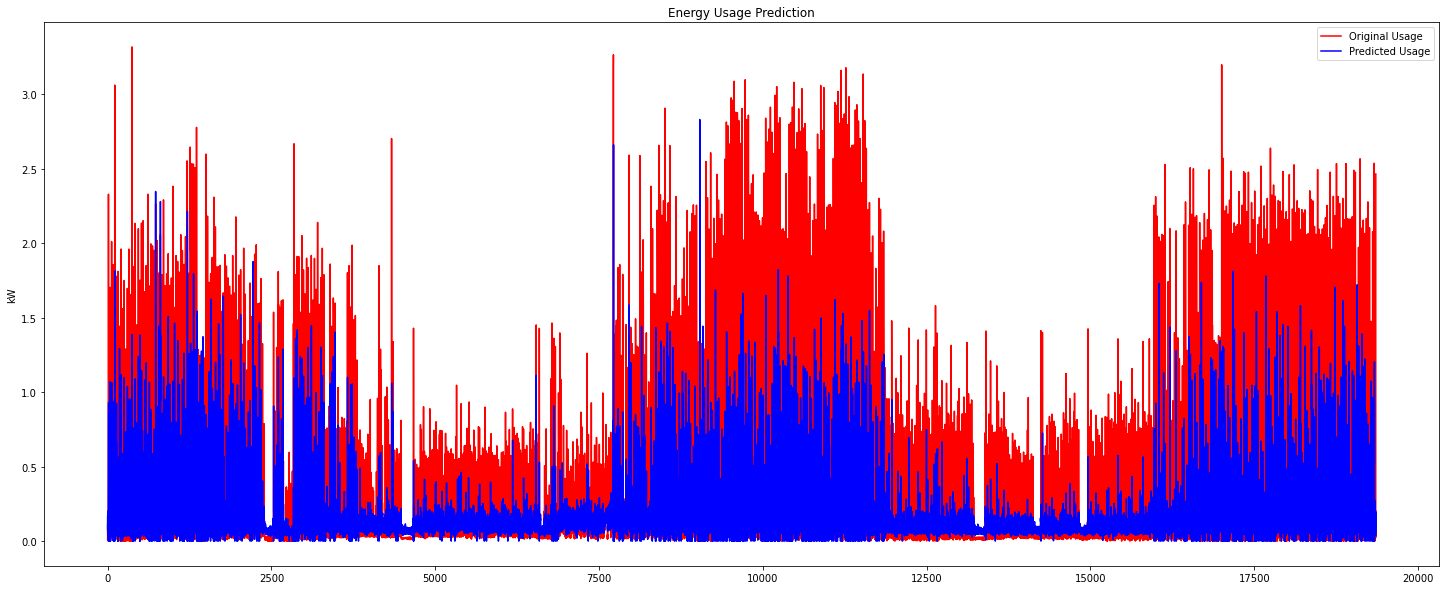

Mean Absolute Percentage Error:  4134355581878.8955
Mean Absolute Error:  0.2178543928735296
Max Absolute Error:  3.1279999
Mean Squared Error:  0.21338585114974368
SPECIFIC--------


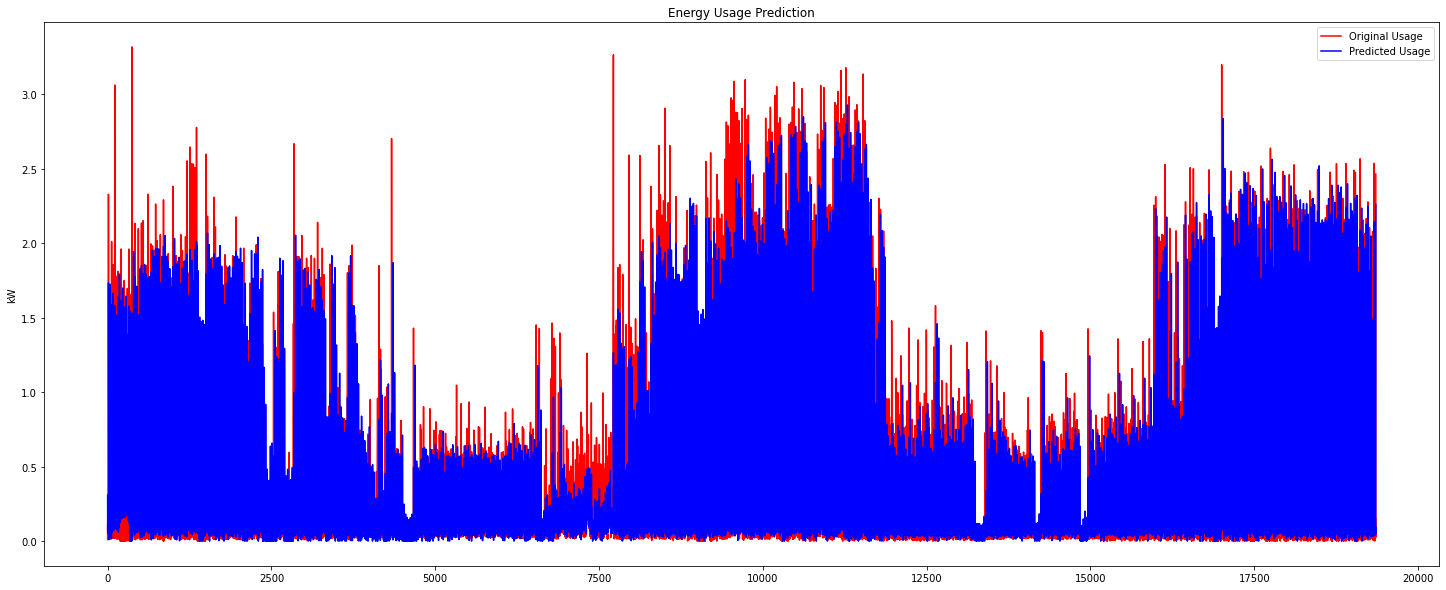

Mean Absolute Percentage Error:  3582428722506.781
Mean Absolute Error:  0.09856335348494183
Max Absolute Error:  2.0446573326109565
Mean Squared Error:  0.03750539801895863
BEST--------


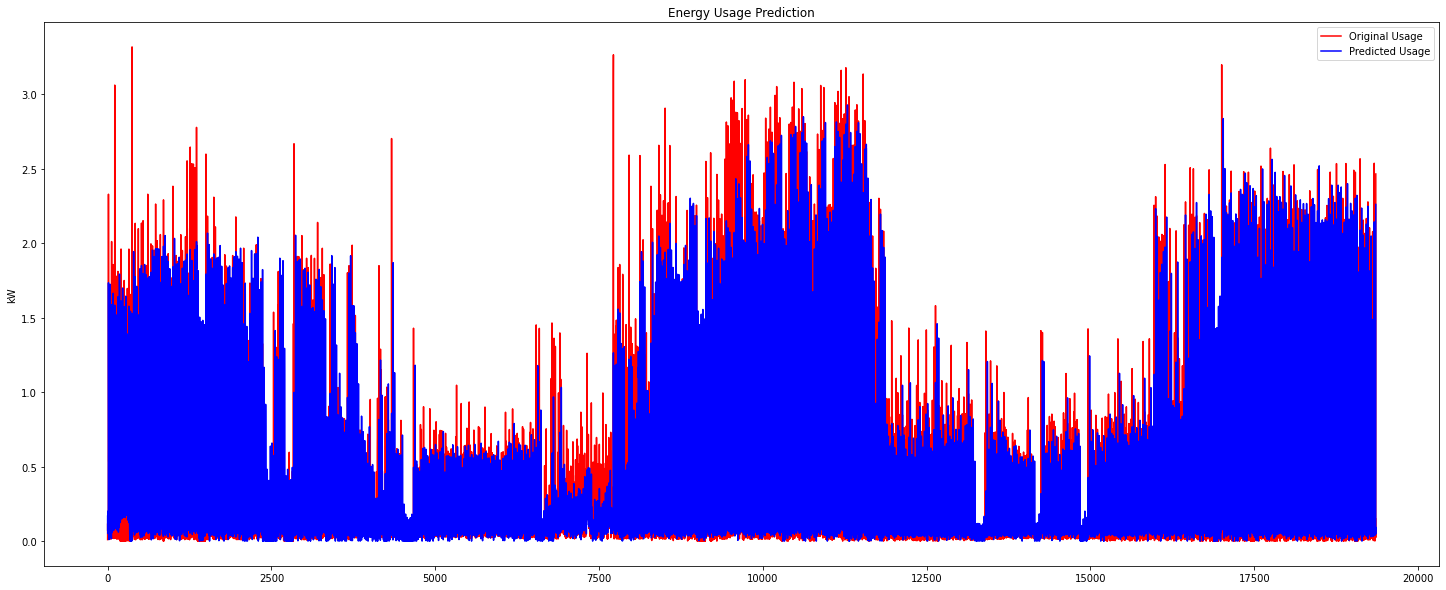

Mean Absolute Percentage Error:  3582428722506.78
Mean Absolute Error:  0.09856875223882537
Max Absolute Error:  2.0446573326109565
Mean Squared Error:  0.03750387787854895


In [20]:
for filename in testHouses:
    print("Testing with ", filename)
    
    generic_prediction = None
    generic_preds = []

    specific_prediction = None
    specific_Model = None
    specific_preds = []
    
    best_model = "generic"
    best_preds = []
    
    true = []
    
    f = os.path.join(directory, filename)
    if os.path.isfile(f):
        df = pd.read_csv(f, delimiter = ',')
        #df = df.iloc[:10000 , :]

        
    specific_x_scaler = StandardScaler()
    specific_y_scaler = StandardScaler()
    
    #new dataframe step by step
    d = {key:[] for key in df.columns}
    userKnownDf = pd.DataFrame(data=d)
    
    hourIndex = 0
    for index, row in df.iterrows():
        hourIndex += 1
        
        #Read new values
        userKnownDf = userKnownDf.append(row)
        if len(userKnownDf) > 24*365:
            userKnownDf = userKnownDf.iloc[1:]
        
        if specific_Model is not None:
            
            #PREDICT NEXT
            
            #Specific Model
            #get last past_Window+1 values, the last value will get ignored by time series generator
            x_test = specific_x_scaler.transform(userKnownDf[featuresNames].iloc[-(past_window + 1):].values)
            y_test = [0 for i in range(past_window+1)] #doesnt matter
            test_generator = TimeseriesGenerator(x_test, y_test, length=past_window, batch_size=1)
            x_test = [arr[0].flatten() for arr in test_generator]
            
            specific_prediction = specific_y_scaler.inverse_transform(specific_Model.predict(x_test))[0]
            specific_prediction = specific_prediction if specific_prediction >= 0 else 0
            
            #generic Model
            x_test = x_scaler.transform(userKnownDf[featuresNames].iloc[-(past_window + 1):].values)
            y_test = [0 for i in range(past_window+1)] #doesnt matter
            test_generator = TimeseriesGenerator(x_test, y_test, length=past_window, batch_size=1)
            
            generic_prediction = y_scaler.inverse_transform(generic_Model.predict(test_generator))[0]
            generic_prediction = generic_prediction if generic_prediction >= 0 else 0

        
            #CHECK LAST PREDICTION
            #get true value
            actualValue = row["use"]
            true.append(actualValue)
            generic_preds.append(generic_prediction)
            specific_preds.append(specific_prediction)
            
            if best_model == "generic":
                best_preds.append(generic_prediction)
                if predict_evaluate(specific_preds[-(7*24):], true[-(7*24):]) < predict_evaluate(generic_preds[-(7*24):], true[-(7*24):]):
                    best_model = "specific"
            else:
                best_preds.append(specific_prediction)
                
        #RETRAIN
        if hourIndex % (7*24) == 0:    #Every Week
            x_train = specific_x_scaler.fit_transform(userKnownDf[featuresNames].values)
            y_train = specific_y_scaler.fit_transform(userKnownDf[targetName].values.reshape(-1,1))
            train_generator = TimeseriesGenerator(x_train, y_train, length=past_window, batch_size=1)
            
            x_train = [arr[0].flatten() for arr in train_generator]
            y_train = [arr[1].flatten() for arr in train_generator]
            
            specific_Model = SVR(kernel = "rbf")
            specific_Model.fit(x_train, y_train)
        
        a = str(hourIndex) + "/" + str(len(df))
        print(a, end="\r")
    
    print("GENERIC--------")
    a = predict_evaluate(generic_preds, true, showplots=True)

    print("SPECIFIC--------")
    a = predict_evaluate(specific_preds, true, showplots=True)
    
    print("BEST--------")
    a = predict_evaluate(best_preds, true, showplots=True)
    
    break
        

## Test generic model for 1 house

Testing with  MAC000032.csv


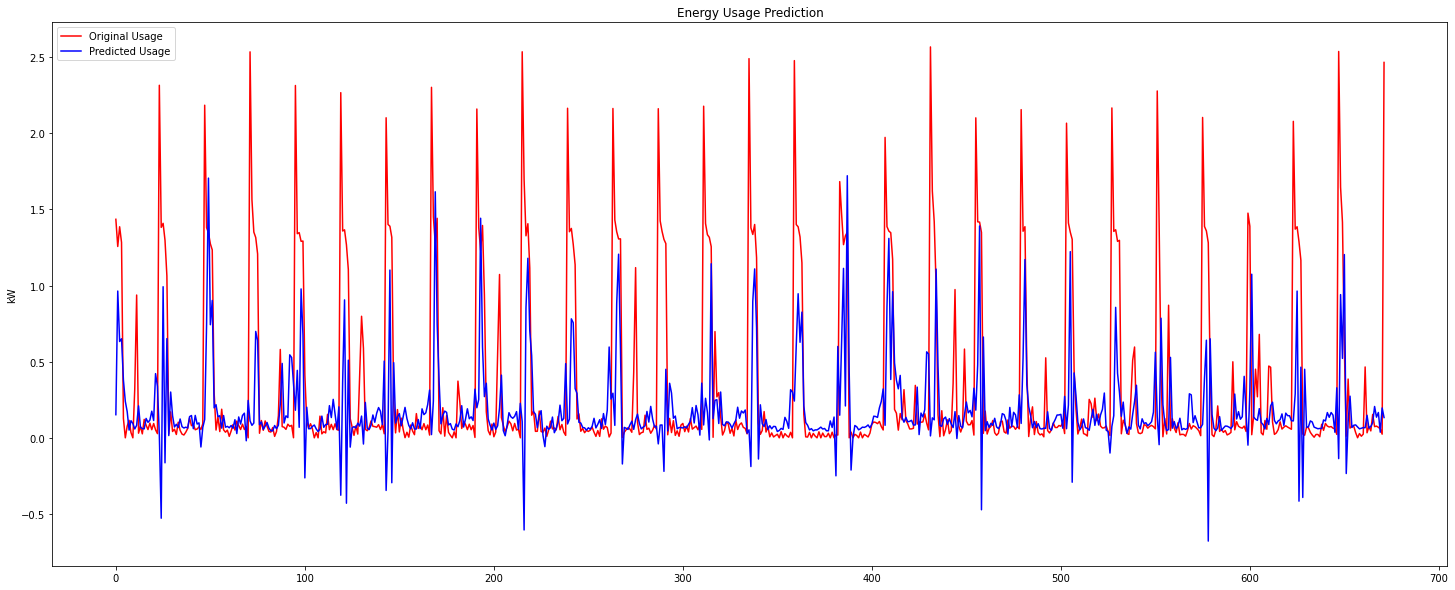

Mean Absolute Percentage Error:  16590499118913.113
Mean Absolute Error:  0.3026242559261142
Max Absolute Error:  [2.67451072]
Mean Squared Error:  0.3607854920316103
Testing with  MAC000091.csv


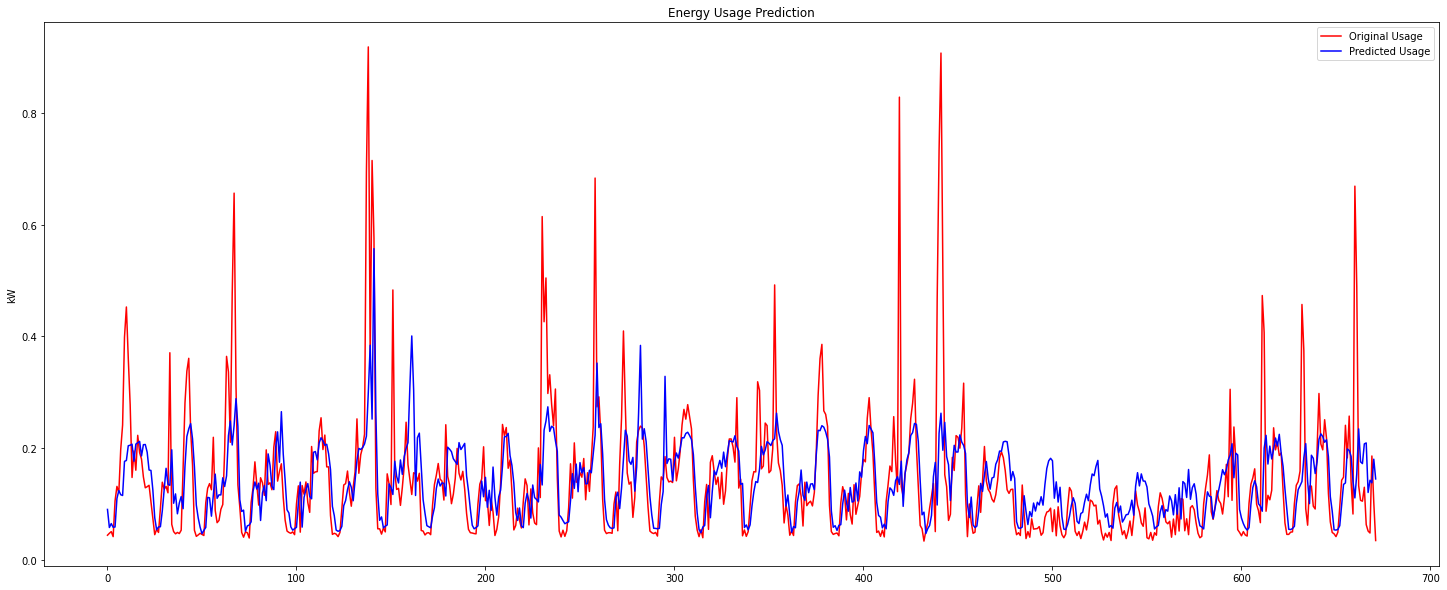

Mean Absolute Percentage Error:  0.46909001566039926
Mean Absolute Error:  0.05577185575949841
Max Absolute Error:  [0.69400317]
Mean Squared Error:  0.009142155222459158
Testing with  MAC000112.csv


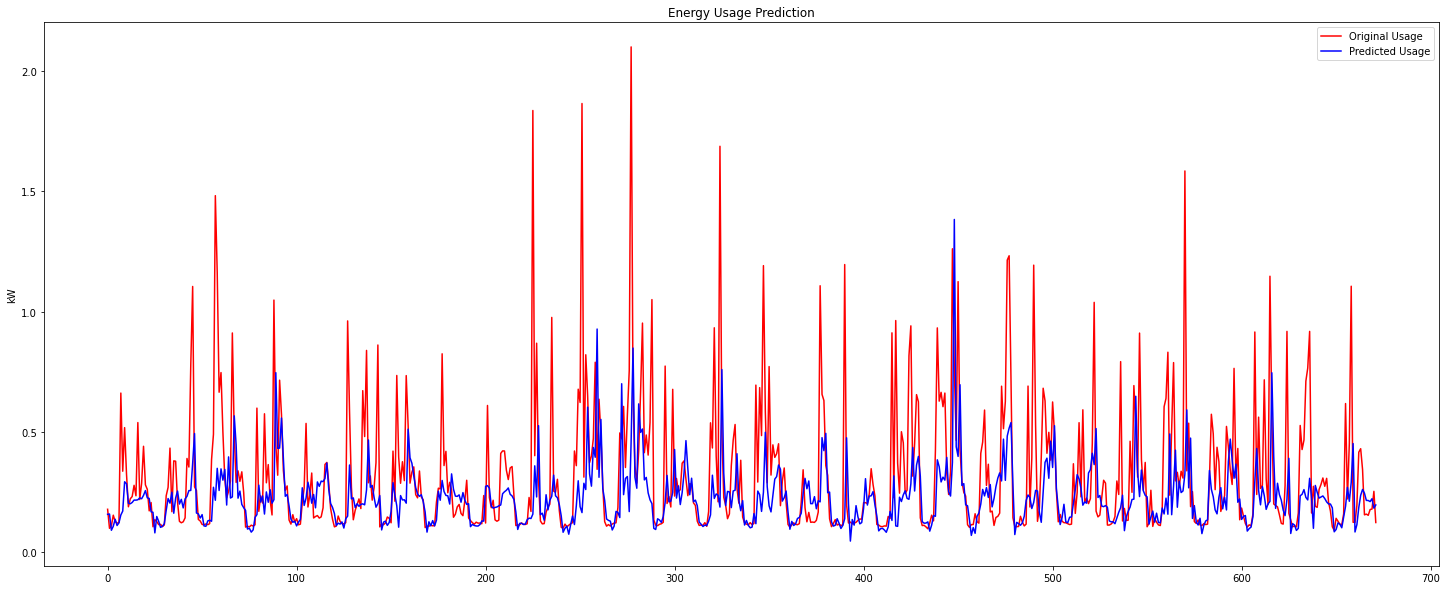

Mean Absolute Percentage Error:  0.3642014316844249
Mean Absolute Error:  0.14939617932350344
Max Absolute Error:  [1.69827819]
Mean Squared Error:  0.07409722038846739
Testing with  MAC000258.csv


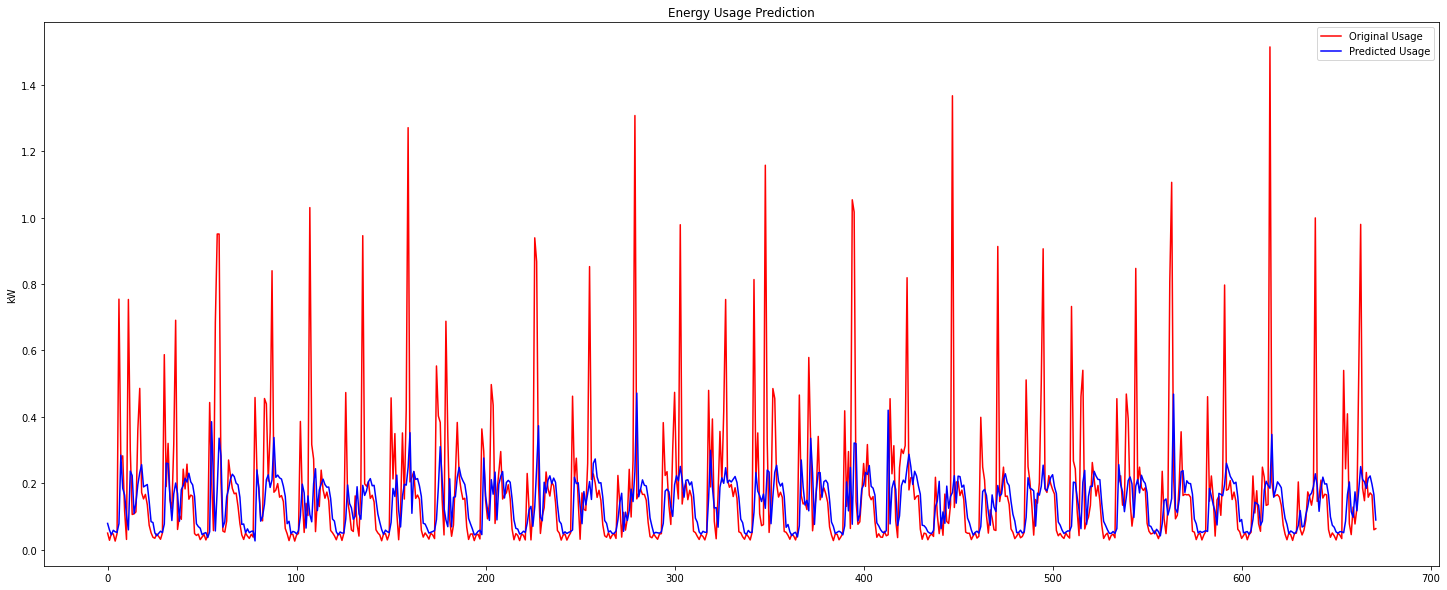

Mean Absolute Percentage Error:  0.5865237124824486
Mean Absolute Error:  0.10095047413634395
Max Absolute Error:  [1.32789263]
Mean Squared Error:  0.04118993278890474
Testing with  MAC000283.csv


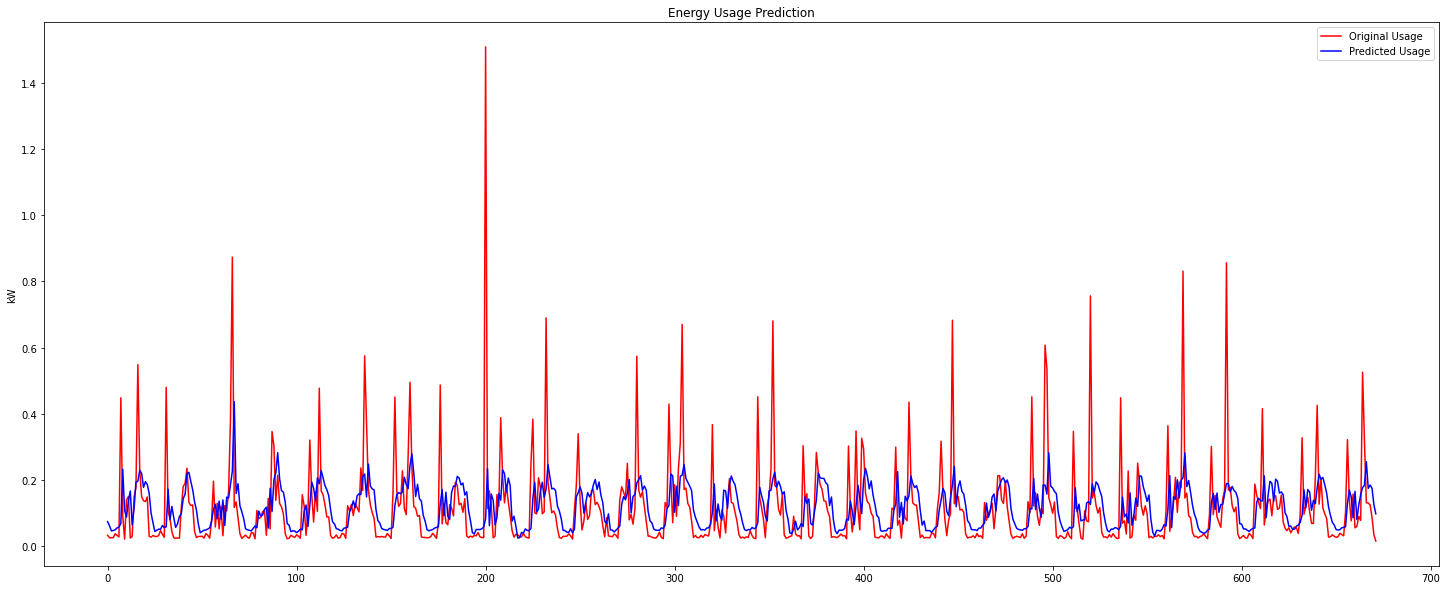

Mean Absolute Percentage Error:  0.8794368498028731
Mean Absolute Error:  0.07002054425856719
Max Absolute Error:  [1.4243668]
Mean Squared Error:  0.015089038476905226
Testing with  MAC000320.csv


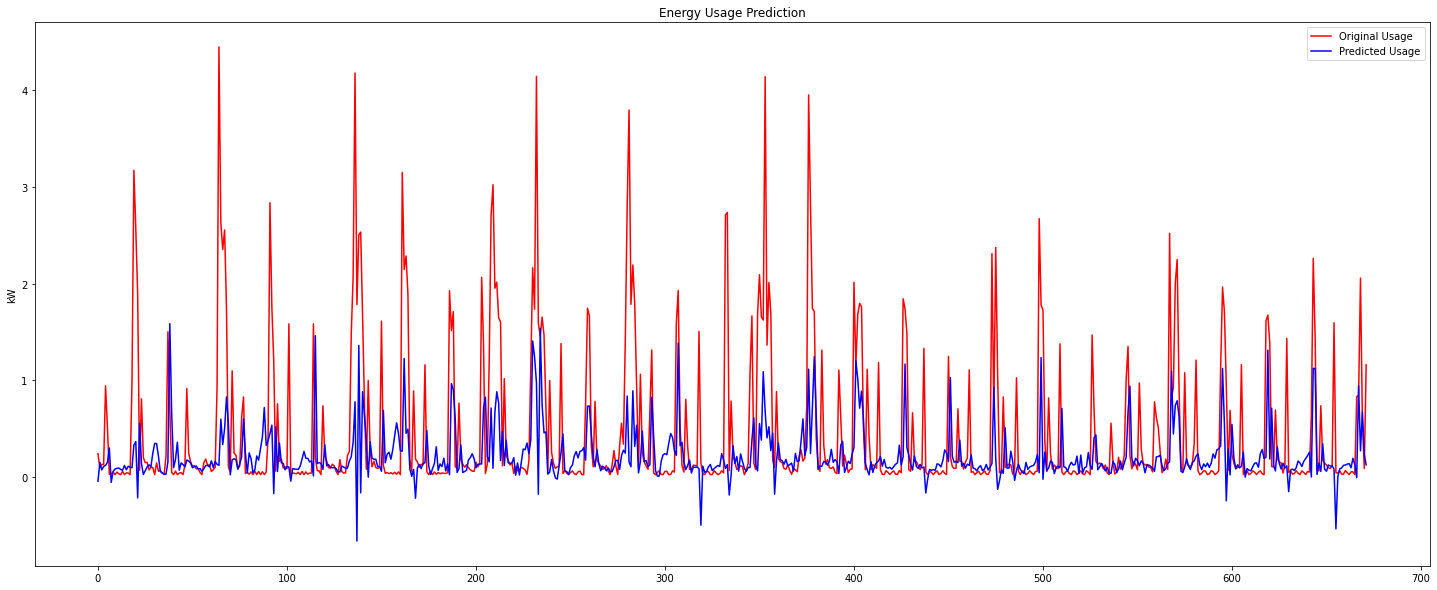

Mean Absolute Percentage Error:  1.6631421205295032
Mean Absolute Error:  0.3884862771031871
Max Absolute Error:  [4.32212491]
Mean Squared Error:  0.5318611700599554
Testing with  MAC000393.csv


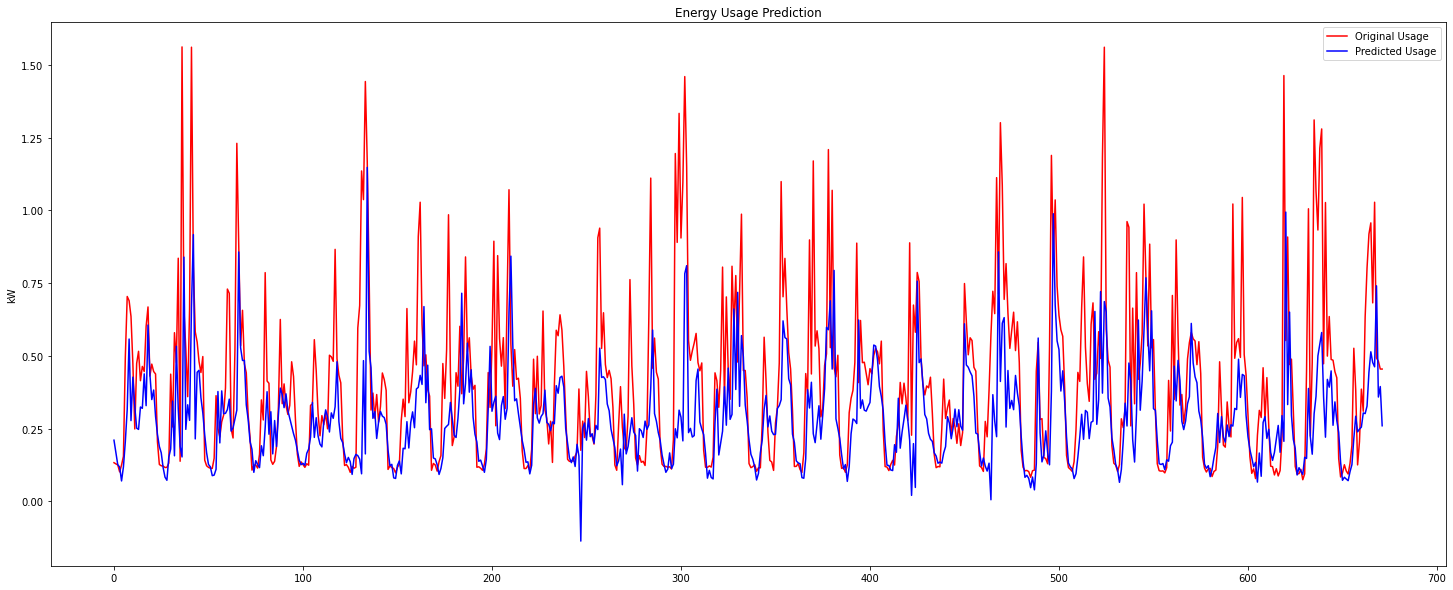

Mean Absolute Percentage Error:  0.3553951794005617
Mean Absolute Error:  0.1684916560670764
Max Absolute Error:  [1.40966474]
Mean Squared Error:  0.07127145123390022
Testing with  MAC000498.csv


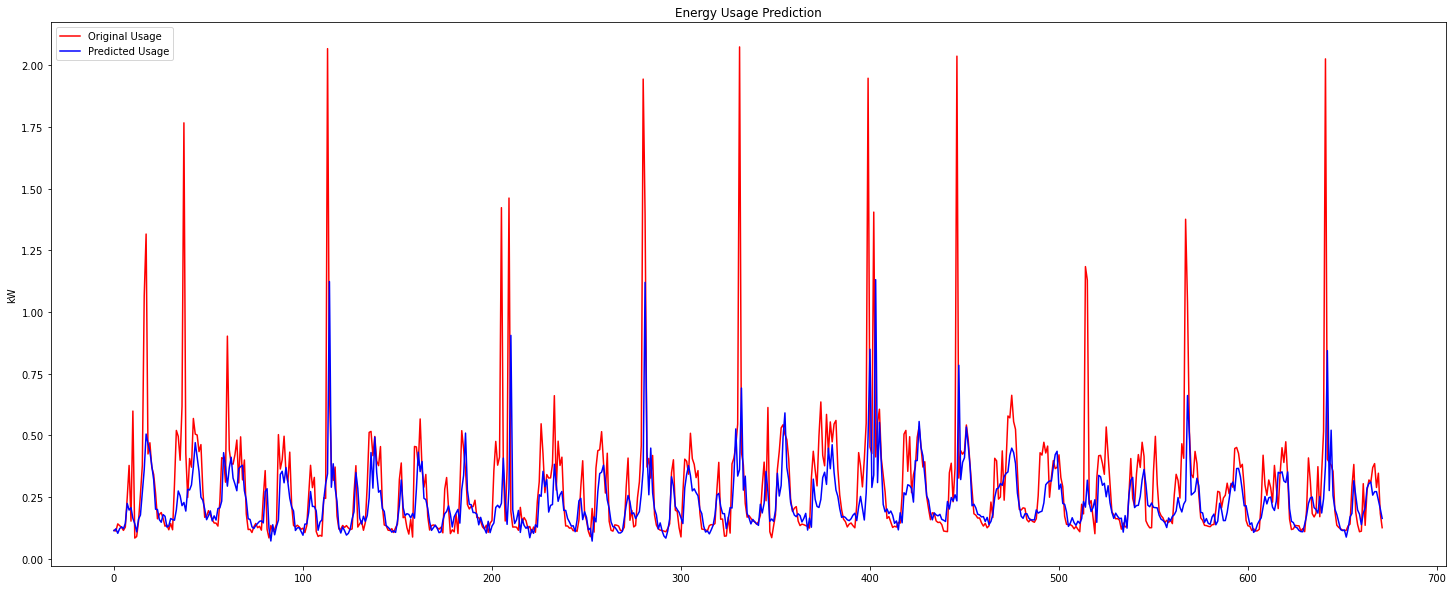

Mean Absolute Percentage Error:  0.2802426730220403
Mean Absolute Error:  0.10275408311476991
Max Absolute Error:  [1.80382747]
Mean Squared Error:  0.05335443433928925
Testing with  MAC000581.csv


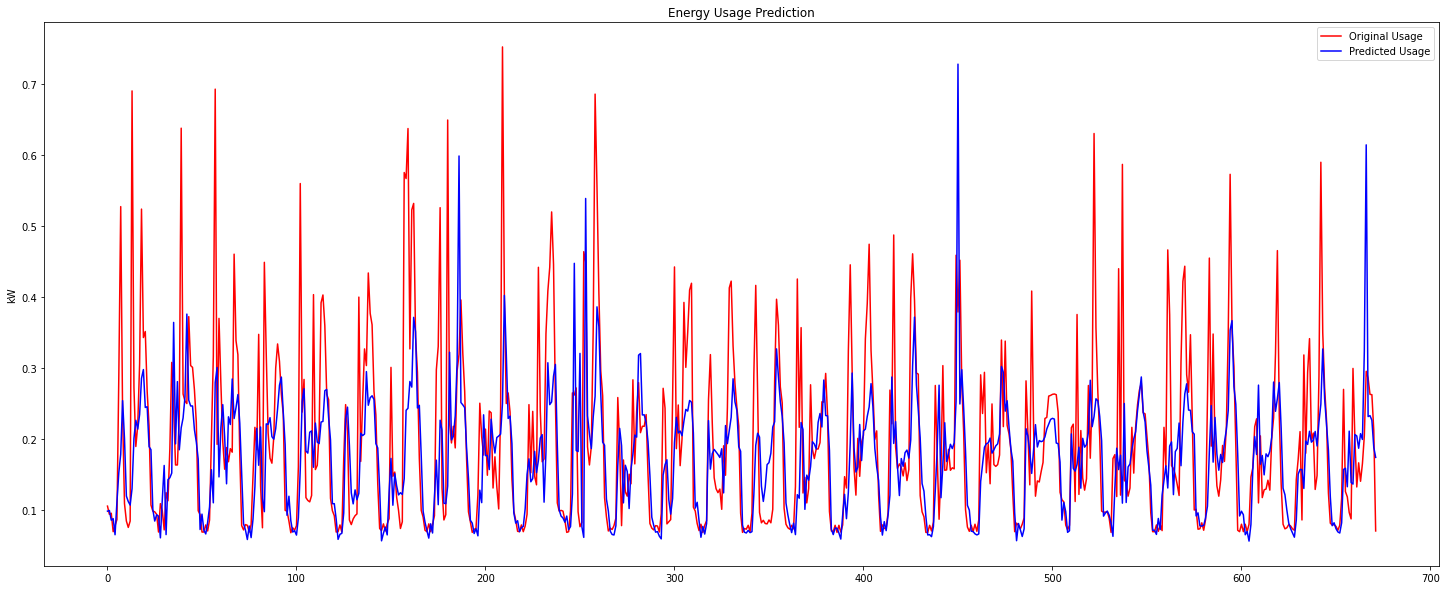

Mean Absolute Percentage Error:  0.3134798098381986
Mean Absolute Error:  0.06567531072508012
Max Absolute Error:  [0.56030196]
Mean Squared Error:  0.01126398701115953
Testing with  MAC000724.csv


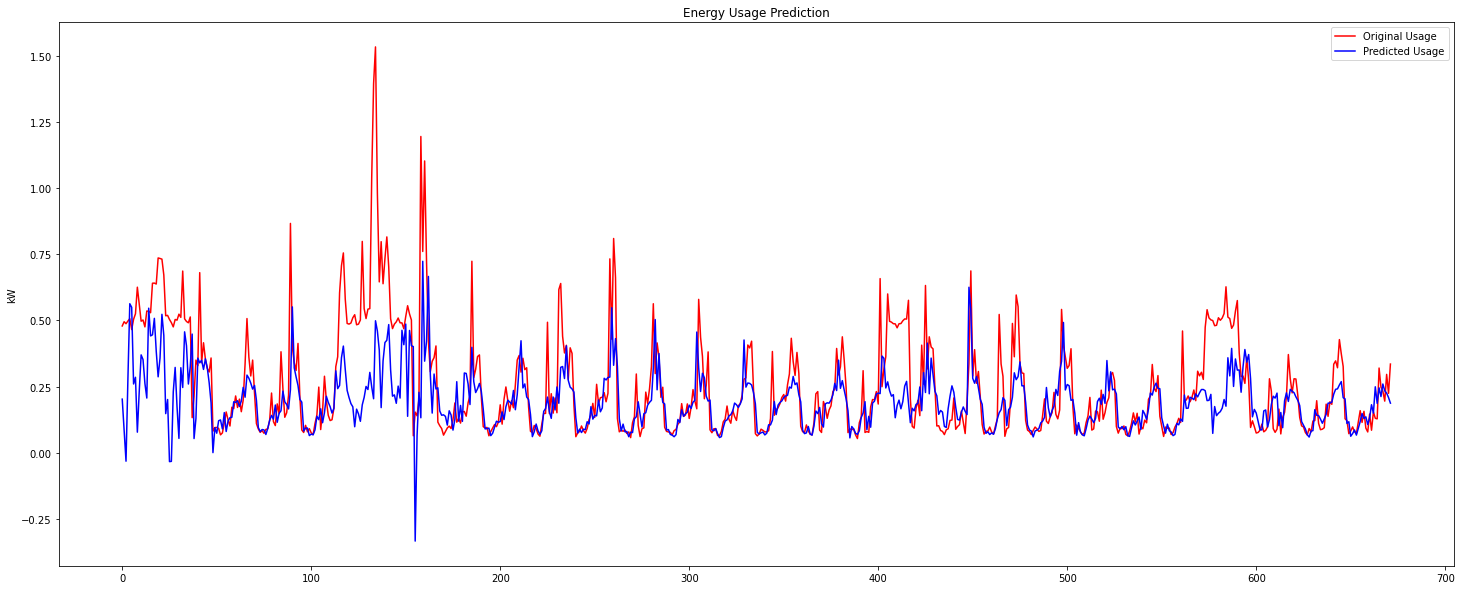

Mean Absolute Percentage Error:  0.37272083468431355
Mean Absolute Error:  0.10501417460794225
Max Absolute Error:  [1.19108719]
Mean Squared Error:  0.030872892384872813
Testing with  MAC001124.csv


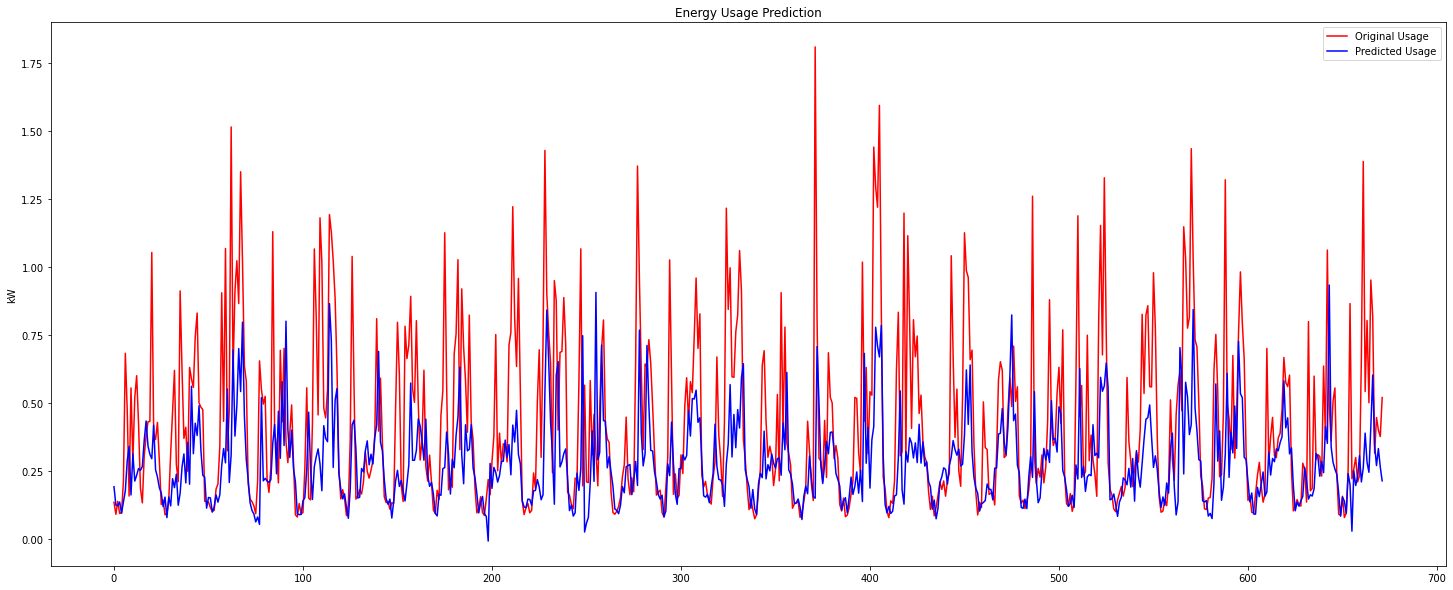

Mean Absolute Percentage Error:  0.38977951173590664
Mean Absolute Error:  0.19480408688466108
Max Absolute Error:  [1.66070946]
Mean Squared Error:  0.09232090267220501
Testing with  MAC001231.csv


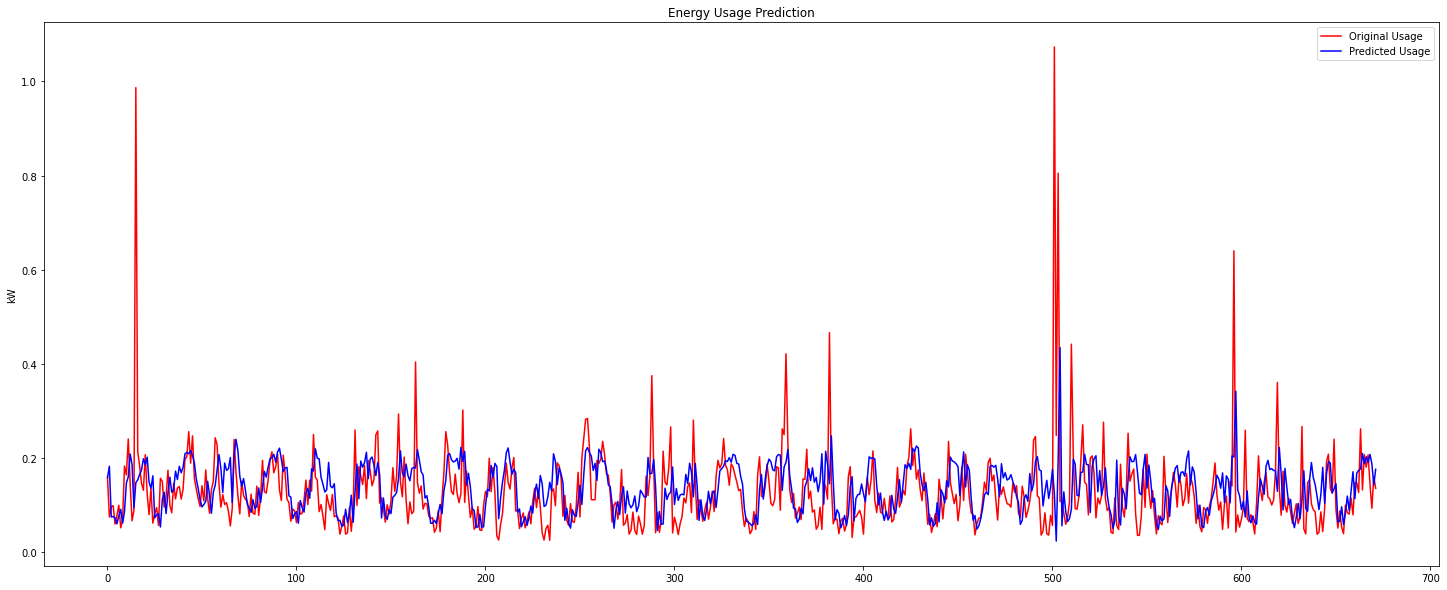

Mean Absolute Percentage Error:  0.5322496450613963
Mean Absolute Error:  0.052957011748561766
Max Absolute Error:  [0.95049538]
Mean Squared Error:  0.007450211344339647
Testing with  MAC001640.csv


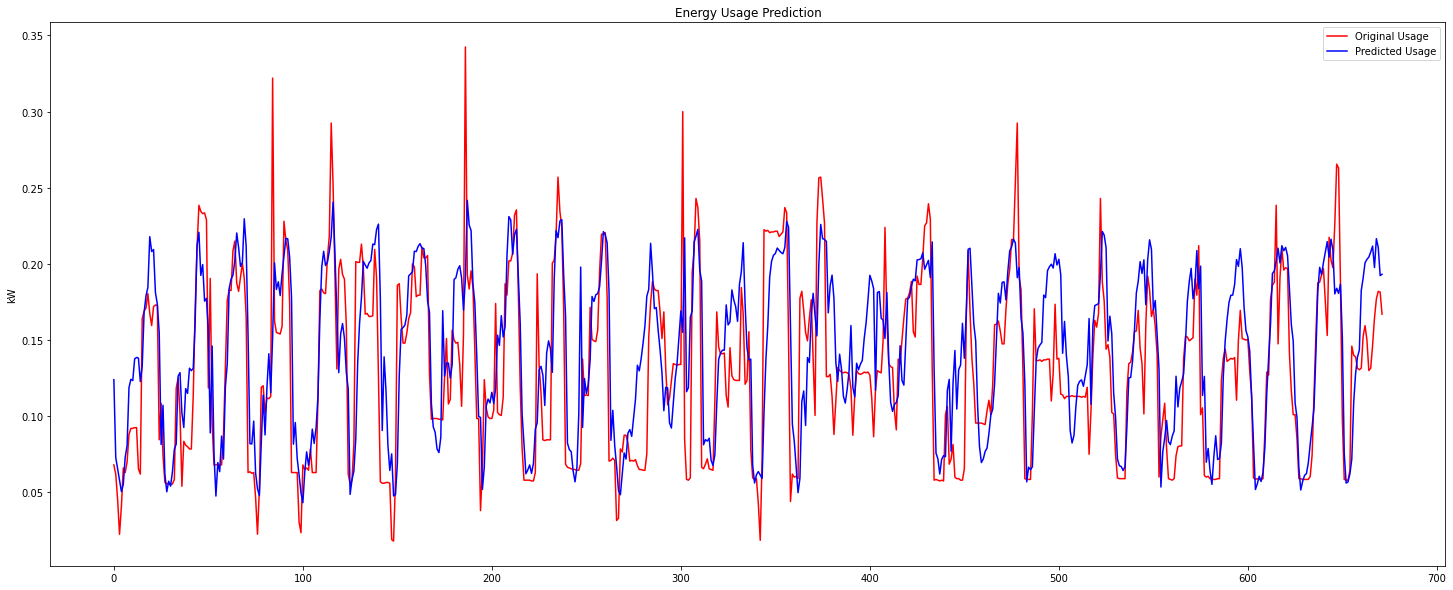

Mean Absolute Percentage Error:  0.29386496087134517
Mean Absolute Error:  0.029897429759436774
Max Absolute Error:  [0.17024565]
Mean Squared Error:  0.0016421140562546666
Testing with  MAC001899.csv


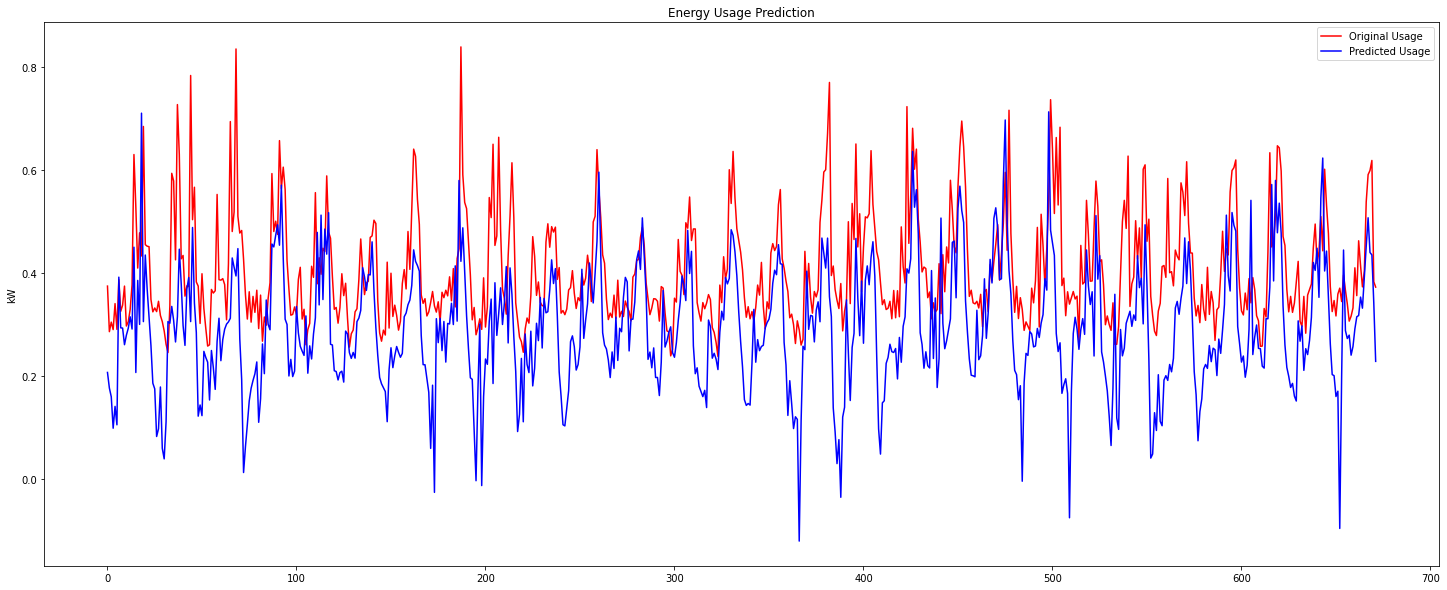

Mean Absolute Percentage Error:  0.31251917961844927
Mean Absolute Error:  0.1265904865199617
Max Absolute Error:  [0.47790351]
Mean Squared Error:  0.023805766740811675
Testing with  MAC002245.csv


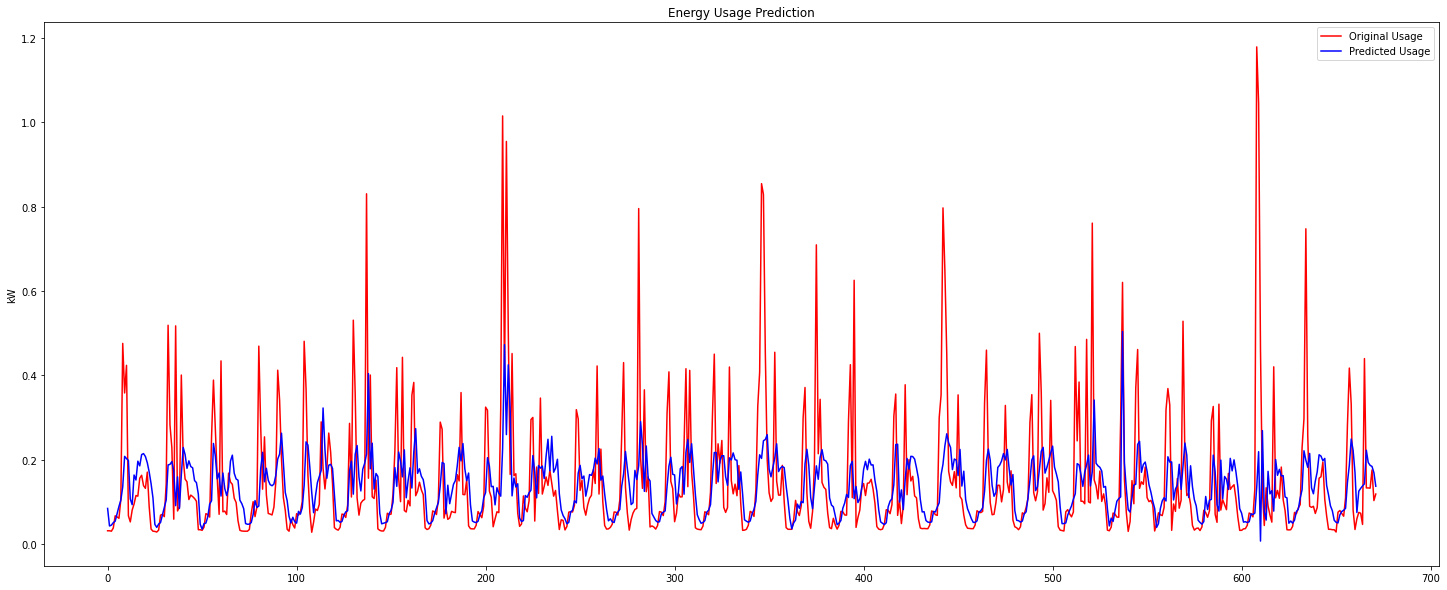

Mean Absolute Percentage Error:  0.628156914235572
Mean Absolute Error:  0.08193953982207222
Max Absolute Error:  [1.04348533]
Mean Squared Error:  0.01890835770381655
Testing with  MAC002449.csv


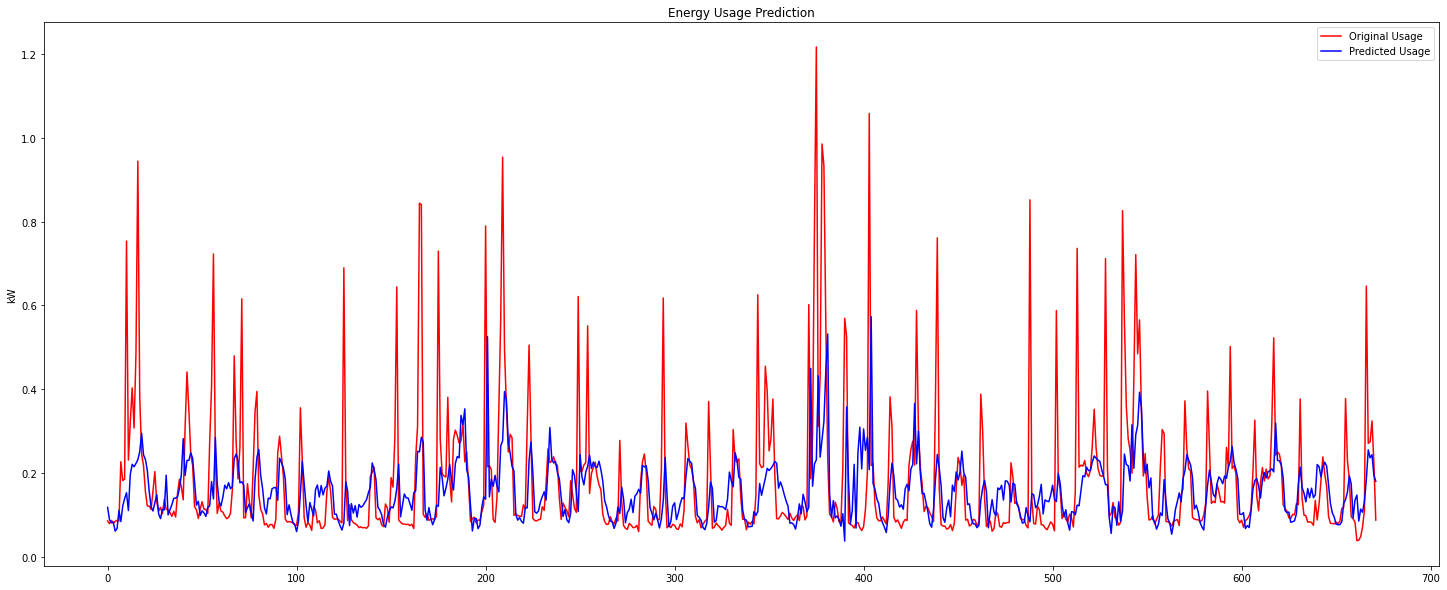

Mean Absolute Percentage Error:  0.4311076474454957
Mean Absolute Error:  0.07896036924789107
Max Absolute Error:  [0.98695122]
Mean Squared Error:  0.0223894959358123
Testing with  MAC002518.csv


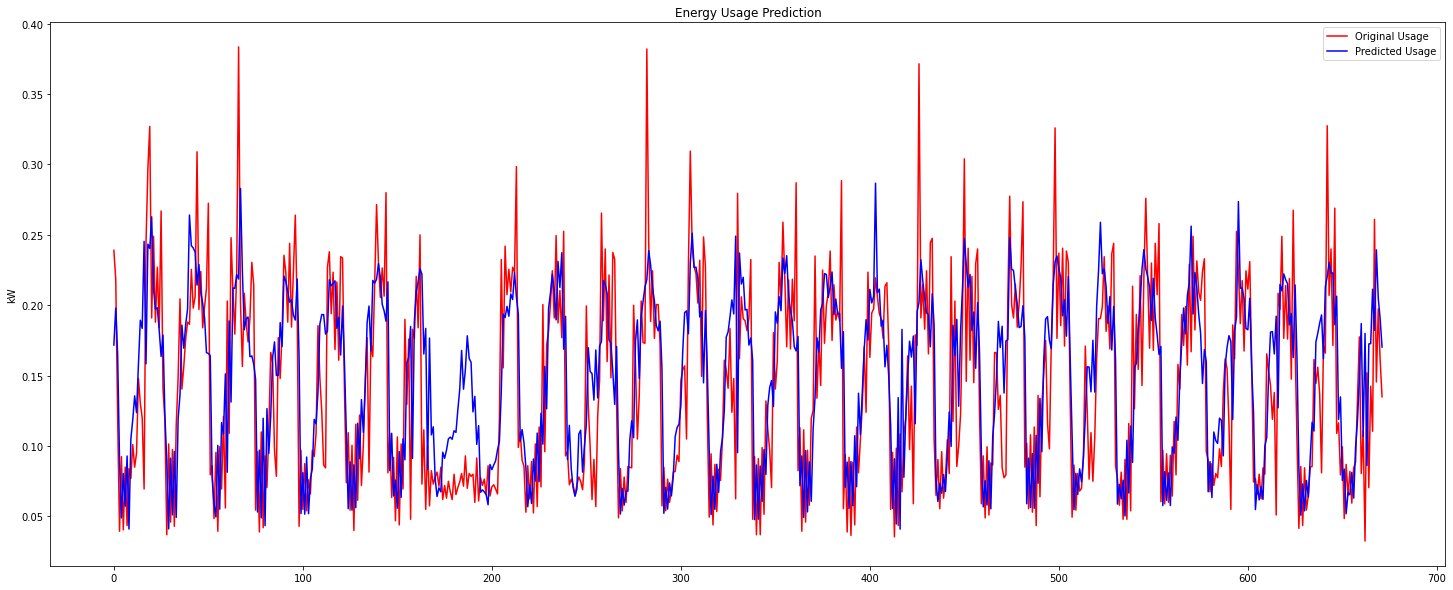

Mean Absolute Percentage Error:  0.4150967013419041
Mean Absolute Error:  0.04217131195233836
Max Absolute Error:  [0.18659587]
Mean Squared Error:  0.0028287189965987454
Testing with  MAC002724.csv


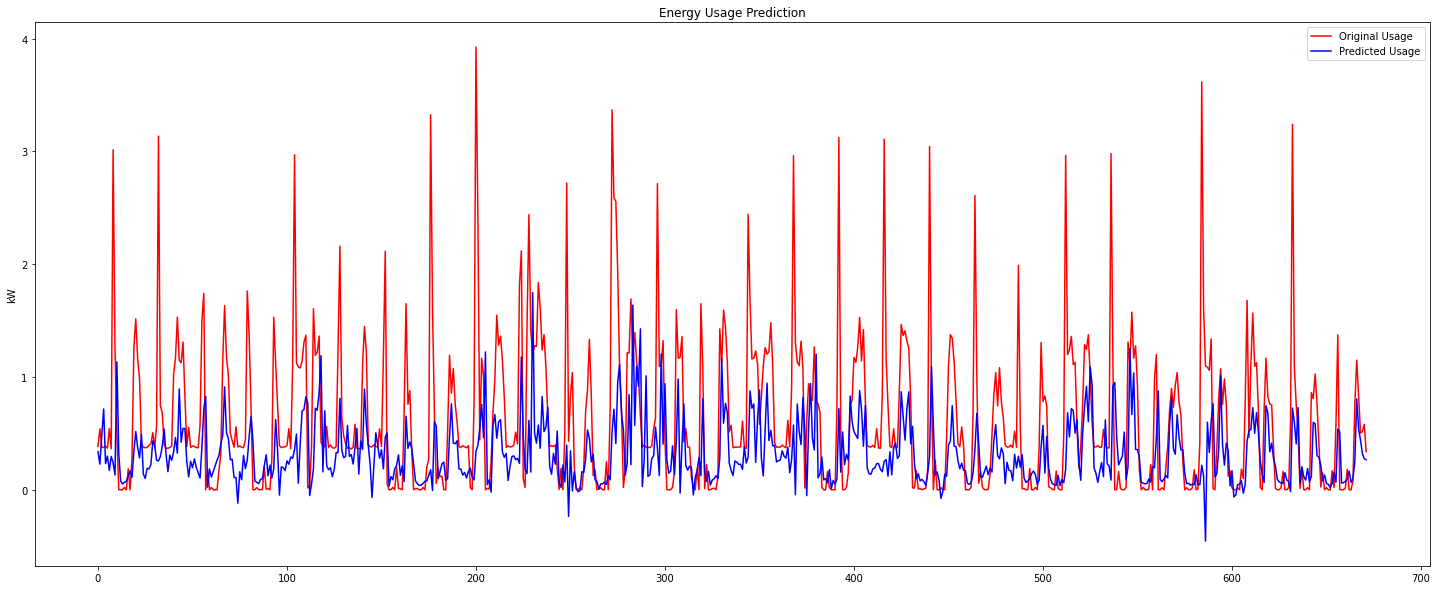

Mean Absolute Percentage Error:  85615913730059.47
Mean Absolute Error:  0.4176155917310235
Max Absolute Error:  [3.58410822]
Mean Squared Error:  0.4458649199569967
Testing with  MAC003163.csv


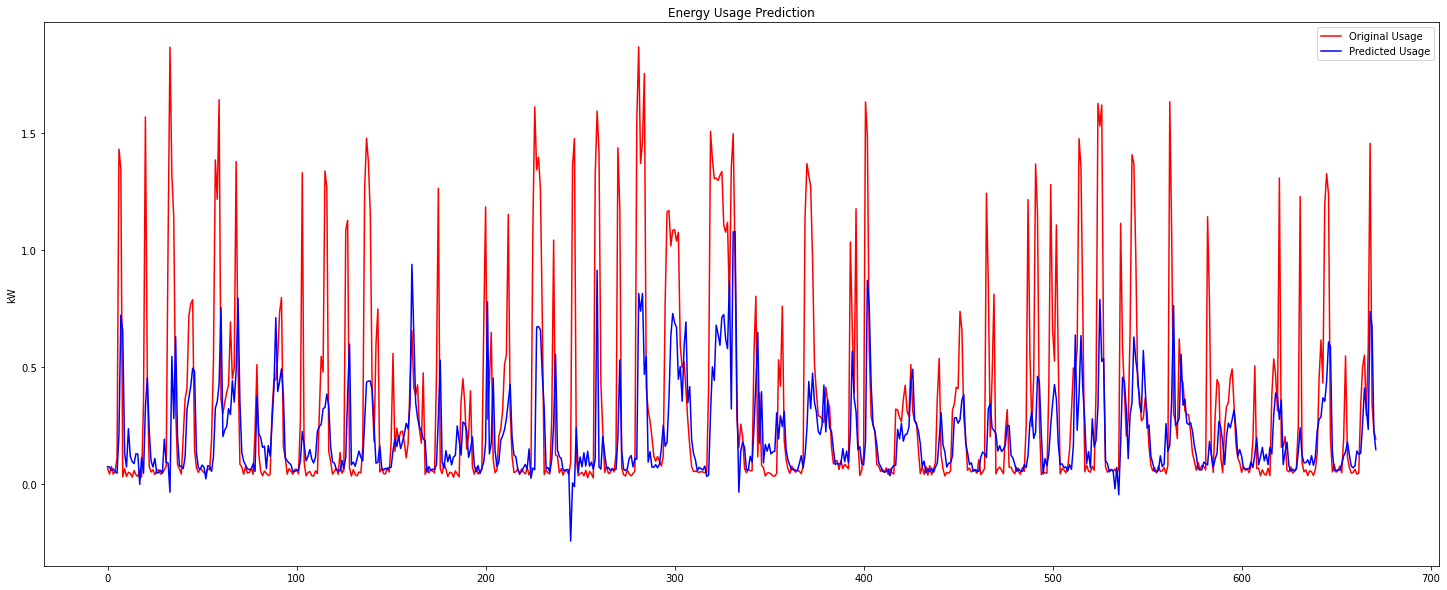

Mean Absolute Percentage Error:  0.8410352439427916
Mean Absolute Error:  0.2155486747834814
Max Absolute Error:  [1.90009752]
Mean Squared Error:  0.14703724378813127
Testing with  MAC003216.csv


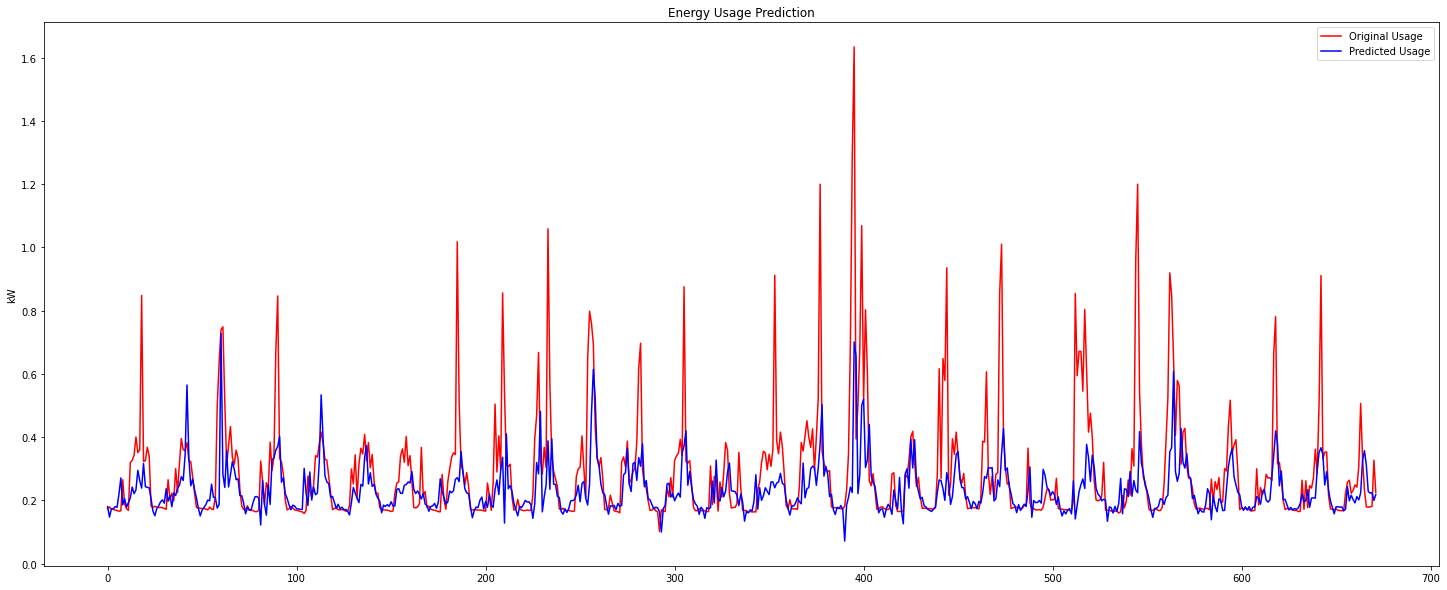

Mean Absolute Percentage Error:  0.2078638301570404
Mean Absolute Error:  0.08212002714438282
Max Absolute Error:  [1.0643078]
Mean Squared Error:  0.025891524788518888


In [14]:
for filename in testHouses:
    print("Testing with ", filename)
    
    f = os.path.join(directory, filename)
    if os.path.isfile(f):
        df = pd.read_csv(f, delimiter = ',')
        
    features = df[featuresNames].values[-(24*30-past_window):]
    target = df[targetName].values[-(24*30-past_window):]

    #SCALE
    x_test = x_scaler.transform(features)
    y_test = y_scaler.transform(target)

    #Time series
    batch_size=64
    test_generator = TimeseriesGenerator(x_test, y_test, length=past_window, batch_size=batch_size)

    prediction = generic_Model.predict(test_generator).reshape(-1, 1)

    prediction = y_scaler.inverse_transform(prediction)


    predict_evaluate(prediction, target[past_window:], showplots=True)